# Exploring Bogota venues across all neighborhoods using the Foursquare API - IBM Data Science Capstone project

In this project an exploration of the Bogota neighborhoods will be done based on the similarity in the venues that each neigborhood posses. This similarty is defined as how may similar places places are in each neighborhood, defined as well as the euclidean distance between every tipe of venue in a defined neighborhood. 

In [1]:
#importing necessary libraries
import pandas as pd
import requests
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

### Data adquirement 

The data used in this project is adquired from a local goverment [site](https://mapas.bogota.gov.co), where a open database of local features of interest are avaible. Among the data avaible we can find the information about every neighborhood, its location, population for every neighborhood, location of sites of interest as schools and hospital location among others types of data. All this data can be download as csv file.  

The structure of the data that will be used in this project is the following. 

| OBJECTID	| Locality Code	| Locality	| Legal Status | Neighborhood | Code | Latitude	| Longitude|
|-----------|---------------|-----------|--------------|--------------|------|----------|----------|

Where every row of the data file contains information about the Locality (Borough), locality code, neighborhood and its geospacial location among other data.

Once the data is avaible, we begin by reading it as a data frame using pandas:

In [2]:
df=pd.read_csv('bogota.csv')
df.rename(columns = {'Codigo Localidad': 'Locality Code', 'Localidad':'Locality', 'Estado':'Legal status',
                    'Nombre':'Neighborhood', 'Codigo':'Code', 'coord_y':'Latitude', 'coord_x':'Longitude'}, inplace = True)
df.head()

OBJECTID  Locality Code   Locality   Legal status  \
0         2              1    Usaquén  SIN LEGALIZAR   
1         6              2  Chapinero  SIN LEGALIZAR   
2         9             10   Engativá  SIN LEGALIZAR   
3        11              1    Usaquén     LEGALIZADO   
4        13              1    Usaquén  SIN LEGALIZAR   

                     Neighborhood    Code           Longitude  \
0  Páramo - Escuela de Caballería   10155       -74,025675896   
1           Pinar Alto - Pinar II   20056       -74,047857714   
2                       Torquigua  100237  -74,14298244349999   
3                        San Luís   10199       -74,019370084   
4                   Tafur Morales   10225      -74,0308703455   

             Latitude  
0   4,679402751153639  
1  4,6618415336530665  
2   4,720715425154963  
3   4,676127045153551  
4   4,736574855155485

The first thing to be notice is the existence of the legal status feature. Some neigborhoods in Bogota are not yet legalized to the local autorities, some others are. Those non-legalized neighborhoods are defined as areas of invasion where people start a comunity most of the times in abandoned areas.

### Legalized Neighborhhods and data cleaning

Lest see how neihborhoods are distribuited in terms of their legal status.

In [3]:
df['Legal status'].value_counts()

SIN LEGALIZAR    2032
LEGALIZADO       1801
URBA                4
CURA                2
LEGA                1
DEFI                1
Name: Legal status, dtype: int64

Almost 2032 small neighborhoods are not legalized in Bogota versus 1801 legalized neigborhoods. An extreme value if the comparision is done.

In [4]:
#lest see the structure of the dataframe
df.shape

(3871, 8)

The first thing to do is separate those legalized neighborhoods from those that are not legalized].

In [5]:
#Lets crate a dataframe 1 where only the legalized neighborhoods are present
ind = df['Legal status']=='LEGALIZADO'
df1 = df[ind]
df1.head()

OBJECTID  Locality Code       Locality Legal status  Neighborhood    Code  \
3         11              1        Usaquén   LEGALIZADO      San Luís   10199   
5         18              3     Candelaria   LEGALIZADO      Lourdes_  170009   
6         19             16  Puente Aranda   LEGALIZADO   Pensilvania  160045   
9         28              1        Usaquén   LEGALIZADO  San Bernardo   10187   
10        37              8        Kennedy   LEGALIZADO  El Porvenir_   80101   

             Longitude            Latitude  
3        -74,019370084   4,676127045153551  
5   -74,07284617350001   4,589327309650732  
6        -74,097477949  4,6125506306514445  
9   -74,03726334450002   4,691520564154034  
10       -74,176961473   4,611728768151443

In [6]:
#lets drops duplicates if any and the non relevant columns
df1.drop_duplicates(subset ="Neighborhood", keep = False, inplace = True)
df1.drop(columns = ['OBJECTID', 'Locality Code', 'Legal status', 'Code'], axis=1, inplace=True)


/usr/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/lib/python3.7/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [7]:
#reset the index and check the resulting frame
df1.reset_index(drop=True, inplace=True)
df1.head()

Locality    Neighborhood           Longitude            Latitude
0     Candelaria        Lourdes_  -74,07284617350001   4,589327309650732
1  Puente Aranda     Pensilvania       -74,097477949  4,6125506306514445
2        Usaquén    San Bernardo  -74,03726334450002   4,691520564154034
3        Kennedy    El Porvenir_       -74,176961473   4,611728768151443
4       Santa Fe  La Paz Central      -74,0647160815    4,60710977465129

In [9]:
#Rearange the columns order
#df1.rename(columns = {'Locality':'Borough'}, inplace = True)
df1 = df1[['Locality', 'Neighborhood', 'Latitude', 'Longitude']]

In [10]:
df1.head()

Locality    Neighborhood            Latitude           Longitude
0     Candelaria        Lourdes_   4,589327309650732  -74,07284617350001
1  Puente Aranda     Pensilvania  4,6125506306514445       -74,097477949
2        Usaquén    San Bernardo   4,691520564154034  -74,03726334450002
3        Kennedy    El Porvenir_   4,611728768151443       -74,176961473
4       Santa Fe  La Paz Central    4,60710977465129      -74,0647160815

This a familar dataframe and its is almost ready to use. Lets check the data types and lets replace the ',' with a '.' for international convention.

In [11]:
#replacing the ',' with a '.'
df1=df1.apply(lambda x: x.str.replace(',','.'))

In [12]:
#transforming the data types of the location columns to numeric  
df1[['Latitude', 'Longitude']]=df1[['Latitude', 'Longitude']].astype('float64')
df1.dtypes

Locality         object
Neighborhood     object
Latitude        float64
Longitude       float64
dtype: object

In [14]:
#lets check how many boroughs and neighborhoods are in the dataframe
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(df1['Locality'].unique()),
        df1.shape[0]
    )
)

The dataframe has 20 boroughs and 1733 neighborhoods.


In [15]:
#creatiing a subset of the df1 for visualization porpouses
dftest = df1[0:1000]

### Legalized Neighborhoods - Geographical distribution

Now lets see how the legalized neighborhoods are distributed in the city.

In [16]:
#Use geopy library to get the latitude and longitude values of Bogota City.
from geopy.geocoders import Nominatim
import folium
address = 'Bogota, CO'

geolocator = Nominatim(user_agent="bo_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Bogota City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Bogota City are 4.59808, -74.0760439.


In [18]:
# create map of Bogota using latitude and longitude values
#This is a first aproximation on the location of the legalized neighborhoods
map_bogota = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, borough, neighborhood in zip(dftest['Latitude'], dftest['Longitude'], dftest['Locality'], dftest['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=4,
        popup=label,
        color='red',
        fill=False,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_bogota)

      
map_bogota

The first thing we can notice is the existence of neighborhoods agglomeration in the peripheral areas of the city. A common issue in Bogota as most of the residencial neighborhoods are located in these zones and the working or office area are located more to the central areas of the city.

### Non Legalized Neighborhoods

Lets do the same process as before but now with the non legalized neighborhoods.

In [19]:
#lets create a new data frame with only the non legalized neighborhoods
ind2 = df['Legal status']=='SIN LEGALIZAR'
df_non = df[ind2]
df_non.head()

OBJECTID  Locality Code   Locality   Legal status  \
0         2              1    Usaquén  SIN LEGALIZAR   
1         6              2  Chapinero  SIN LEGALIZAR   
2         9             10   Engativá  SIN LEGALIZAR   
4        13              1    Usaquén  SIN LEGALIZAR   
7        21              9   Fontibón  SIN LEGALIZAR   

                     Neighborhood    Code           Longitude  \
0  Páramo - Escuela de Caballería   10155       -74,025675896   
1           Pinar Alto - Pinar II   20056       -74,047857714   
2                       Torquigua  100237  -74,14298244349999   
4                   Tafur Morales   10225      -74,0308703455   
7                 Torres del Rubí   90136      -74,1338037045   

             Latitude  
0   4,679402751153639  
1  4,6618415336530665  
2   4,720715425154963  
4   4,736574855155485  
7   4,675729465153539

In [20]:
#lets drop the duplicate values if any and drop the non useful columns
#df_non.drop_duplicates(subset ="Neighborhood", keep = False, inplace = True)
#df_non.drop(columns = ['OBJECTID', 'Locality Code', 'Legal status', 'Code'], axis=1, inplace=True)

In [21]:
#reset the index of the df and check the results
df_non.reset_index(drop=True, inplace=True)
df_non.head()

OBJECTID  Locality Code   Locality   Legal status  \
0         2              1    Usaquén  SIN LEGALIZAR   
1         6              2  Chapinero  SIN LEGALIZAR   
2         9             10   Engativá  SIN LEGALIZAR   
3        13              1    Usaquén  SIN LEGALIZAR   
4        21              9   Fontibón  SIN LEGALIZAR   

                     Neighborhood    Code           Longitude  \
0  Páramo - Escuela de Caballería   10155       -74,025675896   
1           Pinar Alto - Pinar II   20056       -74,047857714   
2                       Torquigua  100237  -74,14298244349999   
3                   Tafur Morales   10225      -74,0308703455   
4                 Torres del Rubí   90136      -74,1338037045   

             Latitude  
0   4,679402751153639  
1  4,6618415336530665  
2   4,720715425154963  
3   4,736574855155485  
4   4,675729465153539

In [23]:
#lets rearange the df to a more familiar form
df_non = df_non[['Locality', 'Neighborhood', 'Latitude', 'Longitude']]

In [24]:
#replace the non internation convention and change the geospatial location types
df_non=df_non.apply(lambda x: x.str.replace(',','.'))
df_non[['Latitude', 'Longitude']]=df_non[['Latitude', 'Longitude']].astype('float64')
df_non.dtypes

Locality         object
Neighborhood     object
Latitude        float64
Longitude       float64
dtype: object

In [26]:
#lets check the resulting information
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(df_non['Locality'].unique()),
        df_non.shape[0]
    )
)

The dataframe has 20 boroughs and 2032 neighborhoods.


In [27]:
# Slicing the second dataframe for visualization purposes
dftest1 = df_non[0:500]

Now lets check how is the geographical distribution on legalizaded vs non legalized neighborhoods

In [28]:
# 
# create map of Bogota using latitude and longitude values
map_bogota_non = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map of non legalized neighborhoods
for lat, lng, borough, neighborhood in zip(dftest1['Latitude'], dftest1['Longitude'], dftest1['Locality'], dftest1['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=4,
        popup=label,
        color='red', # non legalized neighborhoods in red
        fill=False,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_bogota_non)

# add markers to map of legalized neighborhoods
for lat, lng, borough, neighborhood in zip(dftest['Latitude'], dftest['Longitude'], dftest['Locality'], dftest['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=4,
        popup=label,
        color='blue', #legalized neighborhoods in blue
        fill=False,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_bogota_non)
    
map_bogota_non

Some conclusions can be draw inmediatly from the map above, for example not all non legalized neighborhoods are located in the peripherical areas of the city, some are located inside the city near to legalized neighborhoods.  

Some of these called non legalized neighborhoods are conformed of new edifications or new groups of buildings in unused empty areas. **For the current project only the legalized neighborhoods will be considered, leaving for an upcoming work analyze the non legalized neighborhoods.**  

It is now an obligation of the inhabitants of those areas and an obligation for the local authorities to regulate those non legazided neighborhoods, as it's a condition to get state benefits and regulations.

______________

# Venue analysis of legalized neighborhoods in Bogota using the Foursquare API

Now a venue analysis of the legalized neighborhoods is done. As first part we need to stablish a connection with the Foursquare API to get the near venues to a specific location, in this case near the coordinates of each neighborhood.

In [29]:
#Foursquare API connection parameters
CLIENT_ID = '13VWNTJVB1BDLT4BZXBM4OPEY0ON0U1Y4J5W51ULAN111GPX' # your Foursquare ID
CLIENT_SECRET = 'GQ3HMDCTY1JMQSSW5YWDFNF5CUJU1R2DH2PPJ3RINJTQT1ER' # your Foursquare Secret
VERSION = '20190605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 13VWNTJVB1BDLT4BZXBM4OPEY0ON0U1Y4J5W51ULAN111GPX
CLIENT_SECRET:GQ3HMDCTY1JMQSSW5YWDFNF5CUJU1R2DH2PPJ3RINJTQT1ER


In [30]:
#lets check the first neighborhood in our list of neighboorhoods.
df1.loc[0, 'Neighborhood']

'Lourdes_'

In [31]:
#lets retrive the coordinates of this first neighborhood.
neighborhood_latitude = df1.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = df1.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = df1.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Lourdes_ are 4.589327309650732, -74.07284617350001.


In [32]:
#now we define the limit of venues returned by the API as well as the cheking radius
LIMIT = 150 # limit of number of venues returned by Foursquare API
radius = 500 # define radius
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?&client_id=13VWNTJVB1BDLT4BZXBM4OPEY0ON0U1Y4J5W51ULAN111GPX&client_secret=GQ3HMDCTY1JMQSSW5YWDFNF5CUJU1R2DH2PPJ3RINJTQT1ER&v=20190605&ll=4.589327309650732,-74.07284617350001&radius=500&limit=150'

In [33]:
#Checking the results of our first neighborhood
results = requests.get(url).json()
#results

In [34]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [35]:
#transforming the json file to a pandas dataframe
import json
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

name      categories       lat        lng
0      Antiguo Siam  Nightlife Spot  4.592438 -74.070313
1  Alegria's Hostel          Hostel  4.593512 -74.072160
2             Barcu     Art Gallery  4.592616 -74.070445
3   Plaza de Egipto           Plaza  4.592297 -74.069986

In [36]:
#number of venues returned for our first neighborhood
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

4 venues were returned by Foursquare.


In [37]:
#defining a function to do the same as before for all neighborhoods in the dataframe
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [39]:
#saving the vanues for all neighborhoods in Bogota
bogota_venues = getNearbyVenues(names=df1['Neighborhood'],
                                   latitudes=df1['Latitude'],
                                   longitudes=df1['Longitude']
                                  )

In [42]:
#lets find out how many venues were returned
print(bogota_venues.shape)
bogota_venues.head()

(9770, 7)


Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0     Lourdes_               4.589327              -74.072846   
1     Lourdes_               4.589327              -74.072846   
2     Lourdes_               4.589327              -74.072846   
3     Lourdes_               4.589327              -74.072846   
4  Pensilvania               4.612551              -74.097478   

              Venue  Venue Latitude  Venue Longitude    Venue Category  
0      Antiguo Siam        4.592438       -74.070313    Nightlife Spot  
1  Alegria's Hostel        4.593512       -74.072160            Hostel  
2             Barcu        4.592616       -74.070445       Art Gallery  
3   Plaza de Egipto        4.592297       -74.069986             Plaza  
4           Alkosto        4.611314       -74.094911  Department Store

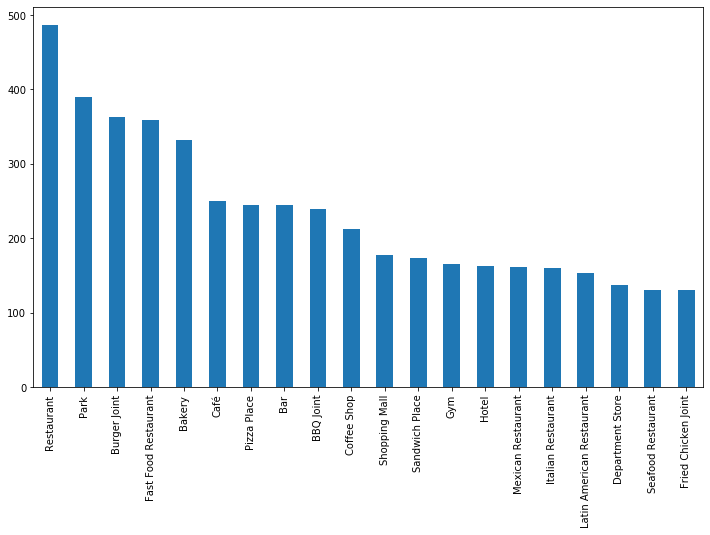

In [43]:
#lets check the top 20 venues by frequency in Bogota
most_freq_venue = bogota_venues['Venue Category'].value_counts().head(20)
most_freq_venue.plot(kind='bar', figsize=(12,7))

As we can see the most common venue in Bogota according to Foursquare are restaurants, followed by parks which confirms the great interest of the past and presents local goverments to improve this aspect of the city. Next we have burgers joints and in general food venues, as well as a malls, gyms and hotels.

In [44]:
#Let's check how many venues were returned for each neighborhood
bogota_venues.groupby('Neighborhood').count().sort_values(by='Venue', ascending =False).head(10)

Neighborhood Latitude  Neighborhood Longitude  Venue  \
Neighborhood                                                                   
Santa Bárbara Oriental                    100                     100    100   
Sagrado_Corazón                           100                     100    100   
La Cabrera                                100                     100    100   
Usaquén                                   100                     100    100   
La_Concordia                              100                     100    100   
La Glorieta                                94                      94     94   
La Catedral                                94                      94     94   
Emaus                                      92                      92     92   
San_Martín                                 85                      85     85   
San Patricio                               73                      73     73   

                        Venue Latitude  Venue Longitude  Venue Category  
Neighborhood                                                             
Santa Bárbara Oriental             100              100             100  
Sagrado_Corazón                    100              100             100  
La Cabrera                         100              100             100  
Usaquén                            100              100             100  
La_Concordia                       100              100             100  
La Glorieta                         94               94              94  
La Catedral                         94               94              94  
Emaus                               92               92              92  
San_Martín                          85               85              85  
San Patricio                        73               73              73

Its worth mention that the request to the API is limted to 100 venues per neighborhood as well as some radius to the central coordinate. Not all the vuenes are returned either for these limitations or because not all venues in Bogota are registered in the Foursquare API. 

In [45]:
#Let's find out how many unique categories can be curated from all the returned venues
print('There are {} uniques categories.'.format(len(bogota_venues['Venue Category'].unique())))

There are 300 uniques categories.


Now its time to encode the results using dummy variables (0 or 1) to denote is some vuene is present or not. For that we use one hot enconding

In [46]:
# one hot encoding
bogota_onehot = pd.get_dummies(bogota_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
bogota_onehot['Neighborhood'] = bogota_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [bogota_onehot.columns[-1]] + list(bogota_onehot.columns[:-1])
bogota_onehot = bogota_onehot[fixed_columns]

bogota_onehot.head()

Zoo  Accessories Store  African Restaurant  Airport  Airport Lounge  \
0    0                  0                   0        0               0   
1    0                  0                   0        0               0   
2    0                  0                   0        0               0   
3    0                  0                   0        0               0   
4    0                  0                   0        0               0   

   Airport Service  Airport Terminal  American Restaurant  Animal Shelter  \
0                0                 0                    0               0   
1                0                 0                    0               0   
2                0                 0                    0               0   
3                0                 0                    0               0   
4                0                 0                    0               0   

   Arcade  ...  Veterinarian  Video Store  Volleyball Court  Warehouse Store  \
0       0  ...             0            0                 0                0   
1       0  ...             0            0                 0                0   
2       0  ...             0            0                 0                0   
3       0  ...             0            0                 0                0   
4       0  ...             0            0                 0                0   

   Water Park  Whisky Bar  Wine Bar  Wings Joint  Women's Store  Yoga Studio  
0           0           0         0            0              0            0  
1           0           0         0            0              0            0  
2           0           0         0            0              0            0  
3           0           0         0            0              0            0  
4           0           0         0            0              0            0  

[5 rows x 300 columns]

Now if some category venue is present it will represented as one otherwise the encoding will be 0.

In [47]:
#lets check the shape of the resulting dataframe
bogota_onehot.shape

(9770, 300)

In [49]:
#Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category
bogota_grouped = bogota_onehot.groupby('Neighborhood').mean().reset_index()
#bogota_grouped

The above results represent the media of ocurrence of the total of category venues groped by neighborhood, which will be usuful to determine the most frequent venue for each neighborhood as to cluster the neighborhoods using the k-mean algorithm.

In [50]:
#Let's print each neighborhood along with the top 5 most common venues
num_top_venues = 5

#for hood in bogota_grouped['Neighborhood']:
#    print("----"+hood+"----")
#    temp = bogota_grouped[bogota_grouped['Neighborhood'] == hood].T.reset_index()
#    temp.columns = ['venue','freq']
#    temp = temp.iloc[1:]
#    temp['freq'] = temp['freq'].astype(float)
#    temp = temp.round({'freq': 2})
#    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
#    print('\n')

#### Commented for readability github reasons

In [51]:
#function to sort the venues in descending order.
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [52]:
#Now let's create the new dataframe and display the top 10 venues for each neighborhood.
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = bogota_grouped['Neighborhood']

for ind in np.arange(bogota_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(bogota_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

Neighborhood 1st Most Common Venue        2nd Most Common Venue  \
0        11 de Noviembre             BBQ Joint         Fast Food Restaurant   
1          12 de Octubre             BBQ Joint         Fast Food Restaurant   
2         8 de Diciembre            Non-Profit                  Yoga Studio   
3        Abraham Lincoln             Gift Shop                         Café   
4  Acacia III Parte Baja       Motorcycle Shop  Eastern European Restaurant   

         3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
0    Latin American Restaurant            Donut Shop            Restaurant   
1    Latin American Restaurant            Donut Shop            Restaurant   
2  Eastern European Restaurant   Empanada Restaurant         Event Service   
3               Breakfast Spot         Shopping Mall           Yoga Studio   
4          Empanada Restaurant         Event Service           Event Space   

    6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
0  Furniture / Home Store        Farmers Market       Motorcycle Shop   
1  Furniture / Home Store        Farmers Market         Movie Theater   
2             Event Space               Exhibit           Fabric Shop   
3                 Factory         Event Service           Event Space   
4                 Exhibit           Fabric Shop               Factory   

       9th Most Common Venue 10th Most Common Venue  
0  South American Restaurant      Fish & Chips Shop  
1  South American Restaurant      Fish & Chips Shop  
2                    Factory     Falafel Restaurant  
3                    Exhibit            Fabric Shop  
4         Falafel Restaurant         Farmers Market

Now it is possible to determine which is the top 10 most common value for each neighborhood. This information allow us to clasify each neighborhood acording to the most and less commo venue. For example for the entry 1, the most common venue are the BBQ joints, and the less common is the fish and ships shops, so it is possible to say that this neighborhood its mostly an eating zone. In the same way we can clasify all the neiborhoods.  

This is valuable information as it can be used to determine what kind of venue is the most frequent and it can be used for some stakeholder to make a market study.

# Classifying the neighborhoods using the K-means algorithm

At this point is possible to use some Machine Learning (ML) algorithms to classify each neigborhood according to the kind of venues present.  

Lets start determining which its the best parameter k for use the algorithm.

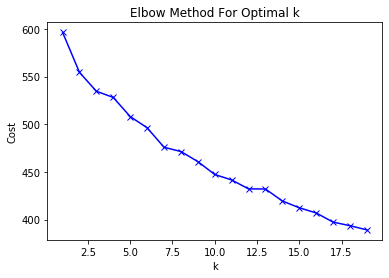

In [53]:
from sklearn.cluster import KMeans
bogota_grouped_clustering = bogota_grouped.drop('Neighborhood', 1)

cost = []
K = range(1,20)

for k in range (1, 20):
    # Create a kmeans model on our data, using k clusters.  random_state helps ensure that the algorithm returns the same results each time.
    kmeans_model = KMeans(n_clusters=k, random_state=1).fit(bogota_grouped_clustering)

    # These are our fitted labels for clusters -- the first cluster has label 0, and the second has label 1.
    
    labels = kmeans_model.labels_

    # Sum of distances of samples to their closest cluster center
    interia = kmeans_model.inertia_
    #print("k:",k, " cost:", interia)
    cost.append(interia)

plt.plot(K, cost, 'bx-')
plt.xlabel('k')
plt.ylabel('Cost')
plt.title('Elbow Method For Optimal k')
plt.show()                


According to the elbow method a good selection for k is k = 7. As k increases, the sum of squared distance tends to zero. Imagine we set k to its maximum value n (where n is number of samples) each sample will form its own cluster meaning sum of squared distances equals zero.


In [55]:

# set number of clusters

kclusters = 7

bogota_grouped_clustering = bogota_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=1).fit(bogota_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:100] 

array([0, 0, 0, 2, 0, 0, 0, 0, 5, 0, 0, 6, 0, 4, 0, 0, 0, 2, 2, 2, 2, 0,
       0, 0, 0, 0, 6, 6, 0, 0, 0, 0, 0, 4, 0, 4, 0, 0, 0, 0, 6, 0, 0, 0,
       0, 4, 4, 0, 5, 0, 0, 6, 6, 0, 0, 0, 0, 0, 4, 4, 4, 6, 0, 0, 2, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 3, 1, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0], dtype=int32)

In [58]:
#reseting indexes and dropiong the labels columns in case of error
df1.reset_index(drop=True)
neighborhoods_venues_sorted.drop('Cluster Labels', axis=1, inplace=True)

In [59]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

bogota_merged = df1

# merge bogota_grouped with bogota_data to add latitude/longitude for each neighborhood
bogota_merged = bogota_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

bogota_merged.head() # check the last columns!

Locality    Neighborhood  Latitude  Longitude  Cluster Labels  \
0     Candelaria        Lourdes_  4.589327 -74.072846             0.0   
1  Puente Aranda     Pensilvania  4.612551 -74.097478             0.0   
2        Usaquén    San Bernardo  4.691521 -74.037263             0.0   
3        Kennedy    El Porvenir_  4.611729 -74.176961             0.0   
4       Santa Fe  La Paz Central  4.607110 -74.064716             0.0   

  1st Most Common Venue          2nd Most Common Venue 3rd Most Common Venue  \
0                Hostel                          Plaza        Nightlife Spot   
1      Department Store  Paper / Office Supplies Store          Soccer Field   
2                 Hotel                           Café            Restaurant   
3            Food Truck             Mexican Restaurant                   Bar   
4        Breakfast Spot      Latin American Restaurant                 Hotel   

       4th Most Common Venue 5th Most Common Venue 6th Most Common Venue  \
0                Art Gallery               Factory   Empanada Restaurant   
1                    Factory   Empanada Restaurant         Event Service   
2                       Park  Gym / Fitness Center     French Restaurant   
3               Burger Joint           Flower Shop           Flea Market   
4  South American Restaurant                  Café                Bakery   

  7th Most Common Venue 8th Most Common Venue     9th Most Common Venue  \
0         Event Service           Event Space                   Exhibit   
1           Event Space               Exhibit               Fabric Shop   
2                Bakery           Supermarket  Bike Rental / Bike Share   
3           Fish Market                  Food         Fish & Chips Shop   
4           Candy Store            Restaurant           Thai Restaurant   

  10th Most Common Venue  
0            Fabric Shop  
1            Yoga Studio  
2          Shopping Mall  
3    Empanada Restaurant  
4                Theater

In [60]:
#droping NA values if any and transforming the labels to int type
bogota_merged.dropna(inplace=True)
bogota_merged['Cluster Labels'] = bogota_merged['Cluster Labels'].astype('int32')

Now lets see how the cluster looks like in the city map.

In [61]:
import matplotlib.cm as cm
import matplotlib.colors as colors
#let's visualize the resulting clusters
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(bogota_merged['Latitude'], bogota_merged['Longitude'], bogota_merged['Neighborhood'], bogota_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

The first thing we can notice is the existence of a super cluster (red) 0, among all the city. This cluster is definied by a variety of venues like food venues and hotels as the most frequent venues which seems logic, as there is non specific are in the city for those places, we can find them all across the city.  

Next in the cluster purple 1, we can find mostly Construction & Landscaping venues mostly in peripherical areas of the city.

Next in the cluster dark blue 2, we can find mostly Shopping Mall venues with almost no precense of Fabric Shop.

Next in the cluster light blue 3, we can find mostly  Grocery Stores venues with almost no precense of restaurants.

And so on.

### Detailed clustering of neighborhoods by registered foursquare venues.

In [62]:
bogota_merged.loc[bogota_merged['Cluster Labels'] == 0, bogota_merged.columns[[1] + list(range(5, bogota_merged.shape[1]))]]

Neighborhood      1st Most Common Venue  \
0                    Lourdes_                     Hostel   
1                 Pensilvania           Department Store   
2                San Bernardo                      Hotel   
3                El Porvenir_                 Food Truck   
4              La Paz Central             Breakfast Spot   
...                       ...                        ...   
1727               El Mortiño                    Dog Run   
1728  Santa Librada La Sureña                     Bakery   
1729              San_Antonio  Cajun / Creole Restaurant   
1731   Urb. La Coruña del Sur               Dessert Shop   
1732   Policarpa Salavarrieta                Candy Store   

              2nd Most Common Venue   3rd Most Common Venue  \
0                             Plaza          Nightlife Spot   
1     Paper / Office Supplies Store            Soccer Field   
2                              Café              Restaurant   
3                Mexican Restaurant                     Bar   
4         Latin American Restaurant                   Hotel   
...                             ...                     ...   
1727                    Yoga Studio      Falafel Restaurant   
1728         Furniture / Home Store             Yoga Studio   
1729              Mobile Phone Shop             Fish Market   
1731                  Grocery Store          Clothing Store   
1732                      BBQ Joint  Furniture / Home Store   

          4th Most Common Venue 5th Most Common Venue 6th Most Common Venue  \
0                   Art Gallery               Factory   Empanada Restaurant   
1                       Factory   Empanada Restaurant         Event Service   
2                          Park  Gym / Fitness Center     French Restaurant   
3                  Burger Joint           Flower Shop           Flea Market   
4     South American Restaurant                  Café                Bakery   
...                         ...                   ...                   ...   
1727        Empanada Restaurant         Event Service           Event Space   
1728         Falafel Restaurant   Empanada Restaurant         Event Service   
1729               Soccer Field               Factory     Electronics Store   
1731                Bus Station           Yoga Studio         Event Service   
1732  Cajun / Creole Restaurant           Flower Shop           Flea Market   

     7th Most Common Venue 8th Most Common Venue     9th Most Common Venue  \
0            Event Service           Event Space                   Exhibit   
1              Event Space               Exhibit               Fabric Shop   
2                   Bakery           Supermarket  Bike Rental / Bike Share   
3              Fish Market                  Food         Fish & Chips Shop   
4              Candy Store            Restaurant           Thai Restaurant   
...                    ...                   ...                       ...   
1727               Exhibit           Fabric Shop                   Factory   
1728           Event Space               Exhibit               Fabric Shop   
1729   Empanada Restaurant         Event Service               Event Space   
1731           Event Space               Exhibit               Fabric Shop   
1732           Fish Market     Fish & Chips Shop      Fast Food Restaurant   

     10th Most Common Venue  
0               Fabric Shop  
1               Yoga Studio  
2             Shopping Mall  
3       Empanada Restaurant  
4                   Theater  
...                     ...  
1727         Farmers Market  
1728                Factory  
1729                Exhibit  
1731                Factory  
1732         Farmers Market  

[1108 rows x 11 columns]

In [63]:
bogota_merged.loc[bogota_merged['Cluster Labels'] == 1, bogota_merged.columns[[1] + list(range(5, bogota_merged.shape[1]))]]

Neighborhood       1st Most Common Venue  \
34                         Sierra Morena  Construction & Landscaping   
62            Urb. Colmena I Los Pinares  Construction & Landscaping   
78                   San Blass II Sector  Construction & Landscaping   
82          Granjas y Huertas El Ramajal  Construction & Landscaping   
94                               Ramírez  Construction & Landscaping   
152                    Villas de Bolívar  Construction & Landscaping   
296                      Santa Cecilia I  Construction & Landscaping   
316                         Buenos_Aires  Construction & Landscaping   
324                         La Fortaleza  Construction & Landscaping   
374                   Marco Fidel Suárez  Construction & Landscaping   
379                          Pradera Sur  Construction & Landscaping   
381                El Socorro III Sector  Construction & Landscaping   
382              La Tortigua (Mz A.B.C.)  Construction & Landscaping   
388                    San Juan I Sector  Construction & Landscaping   
454                      La Nueva Gloria  Construction & Landscaping   
536                            Cartagena  Construction & Landscaping   
605                    Juan José Rondon_  Construction & Landscaping   
638                         Santa Helena  Construction & Landscaping   
639                      La Carbonera II  Construction & Landscaping   
718                     Santa Cecilia II  Construction & Landscaping   
729                             Soratama  Construction & Landscaping   
797                     Rocío Parte Baja  Construction & Landscaping   
806                          La Tortigua  Construction & Landscaping   
812                            El Jordán  Construction & Landscaping   
813                        Las Viviendas  Construction & Landscaping   
869                           Los Laches  Construction & Landscaping   
882                          Espinos III  Construction & Landscaping   
898                      Barranquillita_  Construction & Landscaping   
1069                 San Antonio Mirador  Construction & Landscaping   
1144                         Villa Cindy  Construction & Landscaping   
1198           Panorama (Antes Altamira)  Construction & Landscaping   
1200                             Quindío  Construction & Landscaping   
1248                          La Aurora_  Construction & Landscaping   
1250                  Socorro III Sector  Construction & Landscaping   
1261                     El Recuerdo_Sur  Construction & Landscaping   
1262                         San Juan II  Construction & Landscaping   
1360                       Santa Viviana  Construction & Landscaping   
1385                           San_Pedro  Construction & Landscaping   
1516  Santa Viviana Sector Vista Hermosa  Construction & Landscaping   
1592                La Providencia Media  Construction & Landscaping   
1622                          Las Palmas  Construction & Landscaping   

            2nd Most Common Venue        3rd Most Common Venue  \
34                    Coffee Shop           Falafel Restaurant   
62                     Print Shop               Cosmetics Shop   
78                     Playground           Falafel Restaurant   
82                     Playground           Falafel Restaurant   
94    Eastern European Restaurant          Empanada Restaurant   
152             Electronics Store            Food & Drink Shop   
296                         Diner           Falafel Restaurant   
316                        Museum           Falafel Restaurant   
324                  Soccer Field  Eastern European Restaurant   
374                Massage Studio           Falafel Restaurant   
379                Massage Studio           Falafel Restaurant   
381                Massage Studio           Falafel Restaurant   
382                    Water Park               Farmers Market   
388                        Bakery           Falafel Restaurant   
454   Eastern

In [64]:
bogota_merged.loc[bogota_merged['Cluster Labels'] == 2, bogota_merged.columns[[1] + list(range(5, bogota_merged.shape[1]))]]

Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
27                      Guiparma             Gift Shop        Breakfast Spot   
89    Orquídea Del Sur II Sector         Shopping Mall   Fried Chicken Joint   
126                 Juan Pablo I         Shopping Mall           Yoga Studio   
196                    El Regalo         Shopping Mall            Restaurant   
208        San Judas La Estación            Restaurant         Shopping Mall   
...                          ...                   ...                   ...   
1581        Rincón de Santa Inés         Shopping Mall                  Park   
1600               San Victorino         Shopping Mall     Mobile Phone Shop   
1632                 El_Porvenir         Shopping Mall             Multiplex   
1633       El Porvenir II Sector         Shopping Mall             Multiplex   
1659          El Carmen Fontibón         Shopping Mall     Food & Drink Shop   

            3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
27                            Gym         Shopping Mall           Fabric Shop   
89                  Deli / Bodega                   Bar           Yoga Studio   
126   Eastern European Restaurant   Empanada Restaurant         Event Service   
196                   Yoga Studio           Fabric Shop     Electronics Store   
208            Miscellaneous Shop    Mexican Restaurant           Yoga Studio   
...                           ...                   ...                   ...   
1581                  Yoga Studio           Fabric Shop     Electronics Store   
1600                Train Station       Motorcycle Shop               Factory   
1632                Big Box Store                  Park           Yoga Studio   
1633                  Yoga Studio               Factory   Empanada Restaurant   
1659                         Park      Department Store           Fabric Shop   

     6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
27       Electronics Store   Empanada Restaurant         Event Service   
89      Falafel Restaurant         Event Service           Event Space   
126            Event Space               Exhibit           Fabric Shop   
196    Empanada Restaurant         Event Service           Event Space   
208    Empanada Restaurant         Event Service           Event Space   
...                    ...                   ...                   ...   
1581   Empanada Restaurant         Event Service           Event Space   
1600   Empanada Restaurant         Event Service           Event Space   
1632               Factory         Event Service           Event Space   
1633         Event Service           Event Space               Exhibit   
1659     Electronics Store   Empanada Restaurant         Event Service   

     9th Most Common Venue 10th Most Common Venue  
27             Event Space                Exhibit  
89                 Exhibit            Fabric Shop  
126                Factory     Falafel Restaurant  
196                Exhibit                Factory  
208                Exhibit            Fabric Shop  
...                    ...                    ...  
1581               Exhibit                Factory  
1600               Exhibit            Fabric Shop  
1632               Exhibit            Fabric Shop  
1633           Fabric Shop     Falafel Restaurant  
1659           Event Space                Exhibit  

[64 rows x 11 columns]

In [65]:
bogota_merged.loc[bogota_merged['Cluster Labels'] == 3, bogota_merged.columns[[1] + list(range(5, bogota_merged.shape[1]))]]

Neighborhood 1st Most Common Venue  \
128                      San_Carlos         Grocery Store   
210                     San_Joaquín         Grocery Store   
211                    San Jorge II         Grocery Store   
214        Ciudadela La Libertad II         Grocery Store   
215                     San Antonio         Grocery Store   
266                     San Juanito         Grocery Store   
576         Pinar del Río II Sector         Grocery Store   
577                       El Amparo          Soccer Field   
660               El Rincón de Bosa         Grocery Store   
693                         El_Rubí         Grocery Store   
998                  Ciudad de Cali         Grocery Store   
1011                   La Concordia         Grocery Store   
1023                 Villa Hermosa_         Grocery Store   
1024                 Barranquillita         Grocery Store   
1093                      San Jorge         Grocery Store   
1119                  Villa Natalia         Grocery Store   
1533  El Jazmín Sector El Triángulo         Grocery Store   

     2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
128            Yoga Studio               Factory     Electronics Store   
210            Yoga Studio               Factory     Electronics Store   
211            Yoga Studio               Factory     Electronics Store   
214            Yoga Studio               Factory     Electronics Store   
215            Yoga Studio               Factory     Electronics Store   
266            Yoga Studio               Factory     Electronics Store   
576         Farmers Market           Yoga Studio               Factory   
577          Grocery Store           Yoga Studio   Empanada Restaurant   
660            Yoga Studio               Factory     Electronics Store   
693            Yoga Studio               Factory     Electronics Store   
998                    Gym           Yoga Studio             Drugstore   
1011           Yoga Studio               Factory     Electronics Store   
1023                   Gym           Yoga Studio             Drugstore   
1024           Yoga Studio               Factory     Electronics Store   
1093           Yoga Studio               Factory     Electronics Store   
1119           Yoga Studio               Factory     Electronics Store   
1533           Yoga Studio               Factory     Electronics Store   

     5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
128    Empanada Restaurant         Event Service           Event Space   
210    Empanada Restaurant         Event Service           Event Space   
211    Empanada Restaurant         Event Service           Event Space   
214    Empanada Restaurant         Event Service           Event Space   
215    Empanada Restaurant         Event Service           Event Space   
266    Empanada Restaurant         Event Service           Event Space   
576      Electronics Store   Empanada Restaurant         Event Service   
577          Event Service           Event Space               Exhibit   
660    Empanada Restaurant         Event Service           Event Space   
693    Empanada Restaurant         Event Service           Event Space   
998      Electronics Store   Empanada Restaurant         Event Service   
1011   Empanada Restaurant         Event Service           Event Space   
1023     Electronics Store   Empanada Restaurant         Event Service   
1024   Empanada Restaurant         Event Service           Event Space   
1093   Empanada Restaurant         Event Service           Event Space   
1119   Empanada Restaurant         Event Service           Event Space   
1533   Empanada Restaurant         Event Service           Event Space   

     8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  
128                Exhibit           Fabric Shop     Falafel Restaurant  
210                Exhibit           Fabric Shop     Falafel Restaurant  
211                Exhibit          

In [66]:
bogota_merged.loc[bogota_merged['Cluster Labels'] == 4, bogota_merged.columns[[1] + list(range(5, bogota_merged.shape[1]))]]

Neighborhood 1st Most Common Venue  \
56                    San Isidro_II                  Park   
57                Urb. Ayacucho Sur                  Park   
58                        El Angulo                  Park   
79        Palermo Sur Los Arrayanes                  Park   
95                   Villa Carolina                  Park   
...                             ...                   ...   
1638  Morena II Sector Villa Sandra                  Park   
1651                    Palermo Sur                  Park   
1664                        Duitama                  Park   
1709               Amparo Cañizares          Soccer Field   
1724                   Eduardo Frei             BBQ Joint   

     2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
56             Yoga Studio               Factory     Electronics Store   
57             Yoga Studio               Factory     Electronics Store   
58          Gymnastics Gym                   Bar           Yoga Studio   
79                  Market           Yoga Studio               Factory   
95             Yoga Studio               Factory     Electronics Store   
...                    ...                   ...                   ...   
1638                Market           Yoga Studio               Factory   
1651                Market           Yoga Studio               Factory   
1664           Yoga Studio               Factory     Electronics Store   
1709                  Park           Yoga Studio     Electronics Store   
1724                  Park           Yoga Studio    Falafel Restaurant   

            5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
56            Empanada Restaurant         Event Service           Event Space   
57            Empanada Restaurant         Event Service           Event Space   
58    Eastern European Restaurant   Empanada Restaurant         Event Service   
79            Empanada Restaurant         Event Service           Event Space   
95            Empanada Restaurant         Event Service           Event Space   
...                           ...                   ...                   ...   
1638          Empanada Restaurant         Event Service           Event Space   
1651          Empanada Restaurant         Event Service           Event Space   
1664          Empanada Restaurant         Event Service           Event Space   
1709          Empanada Restaurant         Event Service           Event Space   
1724                Event Service           Event Space               Exhibit   

     8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  
56                 Exhibit           Fabric Shop     Falafel Restaurant  
57                 Exhibit           Fabric Shop     Falafel Restaurant  
58             Event Space               Exhibit            Fabric Shop  
79                 Exhibit           Fabric Shop     Falafel Restaurant  
95                 Exhibit           Fabric Shop     Falafel Restaurant  
...                    ...                   ...                    ...  
1638               Exhibit           Fabric Shop     Falafel Restaurant  
1651               Exhibit           Fabric Shop     Falafel Restaurant  
1664               Exhibit           Fabric Shop     Falafel Restaurant  
1709               Exhibit           Fabric Shop                Factory  
1724           Fabric Shop               Factory         Farmers Market  

[96 rows x 11 columns]

In [67]:
bogota_merged.loc[bogota_merged['Cluster Labels'] == 5, bogota_merged.columns[[1] + list(range(5, bogota_merged.shape[1]))]]

Neighborhood 1st Most Common Venue    2nd Most Common Venue  \
21    Finca La Esperanza            Restaurant  Health & Beauty Service   
24          Las Mercedes               Theater             Concert Hall   
32    La Laguna Fontibón             BBQ Joint           Sandwich Place   
38         El Libertador         Movie Theater               Restaurant   
47           Los Cerezos  Fast Food Restaurant              Supermarket   
...                  ...                   ...                      ...   
1580           Lombardia            Food Truck              IT Services   
1585           Orquídeas          Burger Joint         Football Stadium   
1666      Resurrección 2   Arts & Crafts Store     Fast Food Restaurant   
1692          Las_Brisas  Fast Food Restaurant                     Park   
1713         Zona Franca  Fast Food Restaurant              Yoga Studio   

     3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
21                Creperie  Fast Food Restaurant   Empanada Restaurant   
24    Fast Food Restaurant               Factory     Electronics Store   
32        Asian Restaurant   Fried Chicken Joint  Fast Food Restaurant   
38      Miscellaneous Shop  Fast Food Restaurant   Empanada Restaurant   
47             Bus Station           Yoga Studio               Factory   
...                    ...                   ...                   ...   
1580                Market  Fast Food Restaurant           Supermarket   
1585  Fast Food Restaurant          Soccer Field    Falafel Restaurant   
1666                  Park            Smoke Shop           Yoga Studio   
1692         Movie Theater           Pizza Place        Sandwich Place   
1713    Falafel Restaurant   Empanada Restaurant         Event Service   

     6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
21           Event Service           Event Space               Exhibit   
24     Empanada Restaurant         Event Service           Event Space   
32             Yoga Studio               Factory         Event Service   
38           Event Service           Event Space               Exhibit   
47     Empanada Restaurant         Event Service           Event Space   
...                    ...                   ...                   ...   
1580               Factory   Empanada Restaurant         Event Service   
1585   Empanada Restaurant         Event Service           Event Space   
1666               Exhibit     Electronics Store   Empanada Restaurant   
1692      Asian Restaurant           Yoga Studio     Electronics Store   
1713           Event Space               Exhibit           Fabric Shop   

     9th Most Common Venue 10th Most Common Venue  
21             Fabric Shop                Factory  
24                 Exhibit            Fabric Shop  
32             Event Space                Exhibit  
38             Fabric Shop                Factory  
47                 Exhibit            Fabric Shop  
...                    ...                    ...  
1580           Event Space                Exhibit  
1585               Exhibit            Fabric Shop  
1666         Event Service            Event Space  
1692   Empanada Restaurant          Event Service  
1713               Factory         Farmers Market  

[111 rows x 11 columns]

In [68]:
bogota_merged.loc[bogota_merged['Cluster Labels'] == 6, bogota_merged.columns[[1] + list(range(5, bogota_merged.shape[1]))]]

Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
12           El Consuelo                   Bar           Yoga Studio   
26             El_Dorado                   Bar           Yoga Studio   
44             El Verdun               Dog Run                   Bar   
55           Granada Sur            Playground                   Bar   
121            Dindalito        Gymnastics Gym                   Bar   
...                  ...                   ...                   ...   
1644         El Muelle I      Business Service                   Bar   
1663  Santa Rosa De Lima                   Bar           Yoga Studio   
1683        San Dionisio                   Bar           Yoga Studio   
1688   Urb. La Herradura    Italian Restaurant                   Bar   
1712      Rocío Oriental                   Bar           Yoga Studio   

     3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
12      Falafel Restaurant   Empanada Restaurant         Event Service   
26      Falafel Restaurant   Empanada Restaurant         Event Service   
44             Yoga Studio    Falafel Restaurant         Event Service   
55             Yoga Studio        Farmers Market         Event Service   
121            Yoga Studio               Factory   Empanada Restaurant   
...                    ...                   ...                   ...   
1644           Yoga Studio    Falafel Restaurant         Event Service   
1663    Falafel Restaurant   Empanada Restaurant         Event Service   
1683    Falafel Restaurant   Empanada Restaurant         Event Service   
1688           Yoga Studio         Event Service           Event Space   
1712    Falafel Restaurant   Empanada Restaurant         Event Service   

     6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
12             Event Space               Exhibit           Fabric Shop   
26             Event Space               Exhibit           Fabric Shop   
44             Event Space               Exhibit           Fabric Shop   
55             Event Space               Exhibit           Fabric Shop   
121          Event Service           Event Space               Exhibit   
...                    ...                   ...                   ...   
1644           Event Space               Exhibit           Fabric Shop   
1663           Event Space               Exhibit           Fabric Shop   
1683           Event Space               Exhibit           Fabric Shop   
1688               Exhibit           Fabric Shop               Factory   
1712           Event Space               Exhibit           Fabric Shop   

     9th Most Common Venue 10th Most Common Venue  
12                 Factory         Farmers Market  
26                 Factory         Farmers Market  
44                 Factory         Farmers Market  
55                 Factory     Falafel Restaurant  
121            Fabric Shop     Falafel Restaurant  
...                    ...                    ...  
1644               Factory         Farmers Market  
1663               Factory         Farmers Market  
1683               Factory         Farmers Market  
1688    Falafel Restaurant         Farmers Market  
1712               Factory         Farmers Market  

[67 rows x 11 columns]